In [1]:
##
## UNet 
##
## Взята идея по описанию из https://github.com/pietz/unet-keras
##
##
## 2017-07-28
##   Добавлены flip+rotation LB=760393
##
##
##
##
##

In [2]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
import sklearn.metrics as skm
from __future__ import print_function

In [3]:
print(np.__version__);
print(pd.__version__);

1.13.1
0.19.2


In [4]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, save_model, load_model, Input, Model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D, UpSampling2D, ZeroPadding2D
from keras.layers import Conv2D, Concatenate, Reshape
from keras.layers import Activation, Dropout, Flatten, Dense, Permute
from keras.layers.normalization import BatchNormalization
import keras.optimizers
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

Using TensorFlow backend.


In [6]:
keras.__version__

'2.0.6'

In [7]:
#---------------------------------------------------------------------

In [8]:
!ls -la ..
#!ls -la ../Data
#!ls -la ../Data/training

total 25
drwxrwxrwx 1 boba boba 4096 июл 26 11:10 .
drwxrwxrwx 1 boba boba    0 июл 25 09:21 ..
drwxrwxrwx 1 boba boba 4096 июл 25 09:23 Data
drwxrwxrwx 1 boba boba    0 июл 25 09:22 Data-Arch
drwxrwxrwx 1 boba boba    0 июл 25 09:26 Data-Keras
drwxrwxrwx 1 boba boba 4096 июл 29 12:48 .git
-rwxrwxrwx 2 boba boba  130 июл  9 12:02 .gitignore
drwxrwxrwx 1 boba boba    0 июл 26 10:11 .ipynb_checkpoints
drwxrwxrwx 1 boba boba  280 июл 29 12:49 Jupyter
drwxrwxrwx 1 boba boba 4096 июл 29 12:49 Jupyter-Net
drwxrwxrwx 1 boba boba 4096 июл 29 12:20 Result
drwxrwxrwx 1 boba boba 4096 июл 28 21:35 Temp
drwxrwxrwx 1 boba boba    0 июл 27 07:53 Work


In [9]:
dirData = '../Data'
dirTemp = '../Temp'
dirWork = '../Work'

dirTest  = os.path.join(dirData,'testing','images')
dirTrain = os.path.join(dirData,'training','images')
dirMask  = os.path.join(dirData,'training','truth')

In [10]:
listTrain = os.listdir(dirTrain)
listMask  = os.listdir(dirMask)
listTest  = os.listdir(dirTest)
listTrain = [xx for xx in listTrain if os.path.splitext(xx)[1]=='.tif']
listMask  = [xx for xx in listMask  if os.path.splitext(xx)[1]=='.png']
listTest  = [xx for xx in listTest  if os.path.splitext(xx)[1]=='.tif']
print(len(listTrain),len(listMask),len(listTest))
print(listTrain[:5],'\n',listMask[:5],'\n',listTest[:5])

168 168 162
['i105404.tif', 'i117557.tif', 'i124017.tif', 'i130790.tif', 'i137857.tif'] 
 ['i105404_mask.png', 'i117557_mask.png', 'i124017_mask.png', 'i130790_mask.png', 'i137857_mask.png'] 
 ['i105047.tif', 'i116596.tif', 'i137649.tif', 'i140176.tif', 'i142099.tif']


In [11]:
if 0 :
    for xx in listTrain[:5] :
        img = cv.imread(os.path.join(dirTrain,xx),-1)
        xxm = os.path.splitext(xx)[0]+"_mask.png"
        msk = cv.imread(os.path.join(dirMask,xxm),-1)
        plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(msk,'gray'); plt.show()
    plt.close()

In [12]:
msk.shape, img.shape, img.min(), img.max(), msk.max(), #img[6:10,6:10], msk[6:10,6:10]

NameError: name 'msk' is not defined

In [13]:
flagGray = False
Gauss    = 5
Median   = 5
if flagGray :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,1)), np.zeros((512,512,1))
else :
    trX, trY, trX0, trY0 = [], [], np.zeros((512,512,3)), np.zeros((512,512,1))

for xx in listTrain :
    img = cv.imread(os.path.join(dirTrain,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    xxm = os.path.splitext(xx)[0]+"_mask.png"
    msk = cv.imread(os.path.join(dirMask,xxm),-1)
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trX0[6:506,6:506,0] = img[:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
    else :
        trX0[6:506,6:506,:] = img[:,:,:]/255.0
        trY0[6:506,6:506,0] = msk[:,:]/255.0
        trY0[trY0>=0.5] = 1.0
    trX.append(trX0.copy())
    trY.append(trY0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trX = np.array(trX)
trY = np.array(trY)

# аугментация
trXX, trYY = trX.copy(), trY.copy()

# flipping
for f in range(-1,2) :
    trXXX, trYYY = trX.copy(), trY.copy()
    for p in range(trXXX.shape[0]) :
        trXXX[p], trYYY[p,:,:,0] = cv.flip(trXXX[p],f), cv.flip(trYYY[p,:,:,0],f)
    trXX = np.vstack([trXX,trXXX])
    trYY = np.vstack([trYY,trYYY])
    print('flip :',f,trXX.shape,trYY.shape)
    
# rotate +-90

# rotate +90
trXXX, trYYY = trX.copy(), trY.copy()
for p in range(trX.shape[0]) :
    for i in range(trX.shape[1]) :
        for j in range(trX.shape[2]) :
            trXXX[p,i,j,:] = trX[p,j,trX.shape[1]-i-1]
            trYYY[p,i,j,:] = trY[p,j,trY.shape[1]-i-1]
trXX = np.vstack([trXX,trXXX])
trYY = np.vstack([trYY,trYYY])
print('rotate +90:',trXX.shape,trYY.shape)

# rotate -90
trXXX, trYYY = trX.copy(), trY.copy()
for p in range(trX.shape[0]) :
    for i in range(trX.shape[1]) :
        for j in range(trX.shape[2]) :
            trXXX[p,i,j,:] = trX[p,trX.shape[2]-j-1,i]
            trYYY[p,i,j,:] = trY[p,trY.shape[2]-j-1,i]
trXX = np.vstack([trXX,trXXX])
trYY = np.vstack([trYY,trYYY])
print('rotate -90:',trXX.shape,trYY.shape)
    
trX, trY = trXX.copy(), trYY.copy()
del trXX,trXXX,trYY,trYYY

# Считаем среднее по каналам и вычитаем из изображений
meanX = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).mean(axis=0)
stdX  = (trX[:,6:-6,6:-6,:].mean(axis=(1,2))).std(axis=0)
for cc in range(meanX.shape[0]) : 
    trX[:,6:-6,6:-6,cc] -= meanX[cc]    
print("mean={} std={}".format(meanX,stdX))
    
trX.shape, trX.min(), trX.max(), trY.shape, trY.min(), trY.max()
#[trY[xx].mean() for xx in range(10)]

flip : -1 (336, 512, 512, 3) (336, 512, 512, 1)
flip : 0 (504, 512, 512, 3) (504, 512, 512, 1)
flip : 1 (672, 512, 512, 3) (672, 512, 512, 1)
rotate +90: (840, 512, 512, 3) (840, 512, 512, 1)
rotate -90: (1008, 512, 512, 3) (1008, 512, 512, 1)
mean=[ 0.6473997   0.48950165  0.70839568] std=[ 0.06249822  0.09179847  0.08778627]


((1008, 512, 512, 3),
 -0.62212117329585415,
 0.48696893986925888,
 (1008, 512, 512, 1),
 0.0,
 1.0)

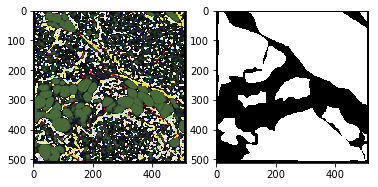

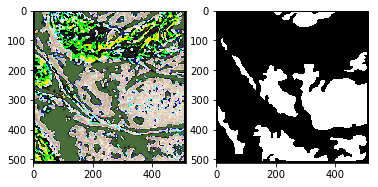

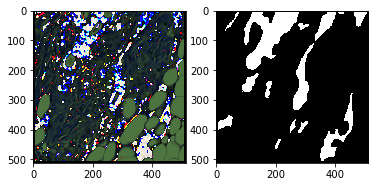

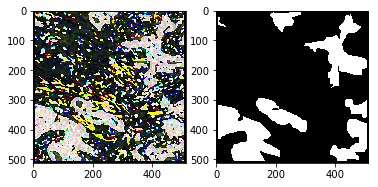

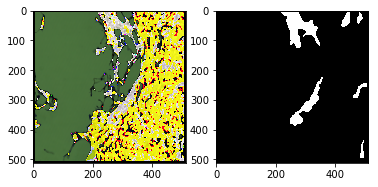

In [14]:
for xx in range(5) :
    img = trX[xx]
    xxm = trY[xx]
    plt.subplot(121); plt.imshow(img); plt.subplot(122); plt.imshow(xxm[:,:,0],'gray'); plt.show()
plt.close()

In [23]:
#
# model UNET
#
#    https://github.com/pietz/unet-keras
#
#

def level_block(m, dim, depth, acti, dropout=0.25, batch=True):
    if depth > 0:
        
        x = m
        if batch : x = BatchNormalization()(x)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(x) #(m)
        n = Conv2D(dim, (3, 3), activation=acti, padding='same')(n)
        if dropout : n = Dropout(dropout)(n) ## add
        m = MaxPooling2D((2, 2))(n)
        m = level_block(m, 2*dim, depth-1, acti, dropout=dropout, batch=batch)
        m = UpSampling2D((2, 2))(m)
        m = Conv2D(dim, (2, 2), activation=acti, padding='same', kernel_initializer='he_normal')(m)
        if dropout : m = Dropout(dropout)(m) ## add
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, (3, 3), activation=acti, padding='same')(m)
    return Conv2D(dim, (3, 3), activation=acti, padding='same')(m)

def UNet(img_shape, n_out=2, dim=32, depth=5, acti='relu', flatten=False, dropout=0.25, batch=True):
    i = Input(shape=img_shape)
    ## ???? i = ZeroPadding2D((6,6),data_format="channels_last")
    o = level_block(i, dim, depth, acti, dropout=dropout, batch=batch)
    o = Conv2D(n_out, (1, 1), name='prediction')(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    #o = Activation('relu')(o)
    if batch : o = BatchNormalization()(o)  ######
    o = Activation('sigmoid')(o)
    return Model(inputs=i, outputs=o)


In [24]:
model10 = UNet((512,512,3),depth=5,n_out=1, dropout=0.05)
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 512, 512, 3)   12          input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_28 (Conv2D)               (None, 512, 512, 32)  896         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
conv2d_29 (Conv2D)               (None, 512, 512, 32)  9248        conv2d_28[0][0]                  
___________________________________________________________________________________________

In [25]:
def dice (truth,pred) :
    g, s = K.sum(truth), K.sum(pred)
    x    = K.sum((truth*pred))
    return((1.0 if K.sum(g+s)==0.0 else 2.0*x/(g+s+K.epsilon())))

def f1 (truth,pred) :
    TP = K.sum(truth*pred)
    TN = K.sum((1.0-truth)*(1.0-pred))
    FP = K.sum(truth*(1.0-pred))
    FN = K.sum((1.0-truth)*pred)

    
    P  = 1.0 if K.sum(TP+FP)==0.0 else TP/(TP+FP)
    R  = 0.0 if K.sum(TP+FN)==0.0 else TP/(TP+FN) 

    F1 = 0.0 if K.sum(P+R)  ==0.0 else 2.0*P*R/(P+R)

    return(F1)

def f1dice (truth,pred) :
    return ((dice(truth,pred)+f1(truth,pred))/2.0)
    
def lossdice (truth,pred) :
    return(1.0 - dice(truth,pred))

def lossfd (truth,pred) :
    return(1.0 - f1dice(truth,pred))
    

In [26]:
def buildModel (input_shape) :
    model = UNet(input_shape,depth=5,n_out=1,dropout=0.05,batch=False)
    
    sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    #model.compile(loss='mean_absolute_error',  #'binary_crossentropy',
    model.compile(loss=lossdice, #'mean_absolute_error',  #'binary_crossentropy',
                  optimizer=sgd, #sgd, #"adam", #'rmsprop',
                  metrics=[dice,'binary_accuracy']) #['binary_accuracy']) #[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])
    return(model)

In [27]:
K.clear_session()
model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
model10.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 512, 512, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 512, 512, 32)  896         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 512, 32)  9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512, 512, 32)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [28]:
#model10.load_weights('../Data-Keras/Models/model-UNet-weights.h5', by_name=False)
batch_size = 1

In [29]:
epochs     = 150
verbose    = 2
batch_size = 1
metric     = 'binary_accuracy'
metric     = 'dice'

############trX, trY = trX[0:30], trY[0:30]

folds      = 5
foldN      = trX.shape[0]/folds+1

print(datetime.datetime.now(),'Training with folds')

#for i in range(folds) :
for i in range(3,6) :

    print(datetime.datetime.now(),'------------>',i)

    K.clear_session()
    model10 = buildModel((trX.shape[1],trX.shape[2],trX.shape[3]))
    ############if 1 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')

#    early_stopping = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.0001,verbose=1)
    early_stopping = EarlyStopping(monitor='loss', patience=10,min_delta=0.0001,verbose=1)
    reduce_lr1     = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.0000001,verbose=1)
    reduce_lr2     = ReduceLROnPlateau(monitor='loss',     factor=0.5,patience=3, min_lr=0.0000001,verbose=1)

    filepath="../Temp/TempTempG5M5KFold2/V1-UNET-val_"+metric+"={val_"+metric+":.4f}-{"+metric+":.4f}---"+str(i)+".hdf5"
    #checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    checkpoint1 = ModelCheckpoint(filepath, monitor=metric,        verbose=1, save_best_only=True, mode='max')
    checkpoint2 = ModelCheckpoint(filepath, monitor='val_'+metric, verbose=1, save_best_only=True, mode='max')

    step  = 60
    low   = 0
    high  = low+step
    
    tFold = [True]*(i*foldN)+[False]*foldN+[True]*trX.shape[0];
    tFold = tFold[:trX.shape[0]]
    
    vFold = [not xx for xx in tFold]

    #hist1  = model10.fit(trX[low:high],trY[low:high],
    hist1  = model10.fit(trX[tFold],trY[tFold],
                        epochs=epochs, batch_size=batch_size, 
                        #validation_split=0.20, 
                        validation_data=(trX[vFold],trY[vFold]),
                        initial_epoch = 0,
                        #callbacks=[early_stopping,reduce_lr1,reduce_lr2,checkpoint],
                        callbacks=[reduce_lr1,reduce_lr2,checkpoint1,checkpoint2,early_stopping],
                        verbose=verbose)

print(datetime.datetime.now())

2017-07-29 13:17:53.157285 Training with folds
2017-07-29 13:17:53.158200 ------------> 3
Train on 806 samples, validate on 202 samples
Epoch 1/150
Epoch 00000: dice improved from -inf to 0.54450, saving model to ../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.6457-0.5445---3.hdf5
Epoch 00000: val_dice improved from -inf to 0.64573, saving model to ../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.6457-0.5445---3.hdf5
481s - loss: 0.4555 - dice: 0.5445 - binary_accuracy: 0.6264 - val_loss: 0.3543 - val_dice: 0.6457 - val_binary_accuracy: 0.8173
Epoch 2/150
Epoch 00001: dice improved from 0.54450 to 0.65599, saving model to ../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.6837-0.6560---3.hdf5
Epoch 00001: val_dice improved from 0.64573 to 0.68365, saving model to ../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.6837-0.6560---3.hdf5
406s - loss: 0.3440 - dice: 0.6560 - binary_accuracy: 0.8210 - val_loss: 0.3163 - val_dice: 0.6837 - val_binary_accuracy: 0.8521
Epoch 3/150
Epoch 00002: dice improved f

KeyboardInterrupt: 

In [30]:
#!ls ../Temp/TempTempG5M5KFold -la | tail
!ls ../Temp/TempTempG5M5KFold2 -la | tail

-rwxrwxrwx 1 boba boba 248917120 июл 29 18:20 V1-UNET-val_dice=0.8207-0.8627---3.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 18:07 V1-UNET-val_dice=0.8210-0.8561---3.hdf5
-rwxrwxrwx 1 boba boba 248917128 июл 29 09:40 V1-UNET-val_dice=0.8217-0.8655---1.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 19:06 V1-UNET-val_dice=0.8218-0.8755---3.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 18:40 V1-UNET-val_dice=0.8219-0.8671---3.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 18:47 V1-UNET-val_dice=0.8219-0.8693---3.hdf5
-rwxrwxrwx 1 boba boba 248917128 июл 29 09:27 V1-UNET-val_dice=0.8221-0.8590---1.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 18:14 V1-UNET-val_dice=0.8223-0.8596---3.hdf5
-rwxrwxrwx 1 boba boba 248917128 июл 29 09:01 V1-UNET-val_dice=0.8224-0.8516---1.hdf5
-rwxrwxrwx 1 boba boba 248917120 июл 29 18:27 V1-UNET-val_dice=0.8227-0.8643---3.hdf5


In [32]:
if 0 : model10 = load_model('../Temp/TrainModel001+G+M/V1-UNET-0.8511.hdf5')
if 0 : model10 = load_model('../Temp/V1-UNET-0.8853.hdf5')
#if 1 : model10 = load_model('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempM3/V1-UNET-0.9054.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5/V1-UNET-val_dice=0.7307.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold/V1-UNET-val_dice=0.7879-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7632-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7660-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFoldMean/V1-UNET-val_dice=0.7828-2.hdf5')
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.8224-0.8516---1.hdf5') # 769128
if 0 : model10.load_weights('../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.8217-0.8655---1.hdf5') # 765XXX
if 1 : model10.load_weights('../Temp/TempTempG5M5KFold2/V1-UNET-val_dice=0.8227-0.8643---3.hdf5')    

In [33]:
%time trP = model10.predict(trX,batch_size=batch_size)

CPU times: user 1min 35s, sys: 22.9 s, total: 1min 58s
Wall time: 2min 26s


In [34]:
trP01 = trP
trP01[trP>0.5] =1.0
trP01[trP<=0.5]=0.0
trP01 = trP01.astype(np.uint8)

In [35]:
if 0 : # Ощутимых результатов не дает, увеличение в +10-100
    times, medianP = 3,5
    for i in range(trP01.shape[0]) :
        for j in range(times) :
            trP01[i,:,:,0] = cv.medianBlur(trP01[i],medianP)

(512, 512, 3) (512, 512, 1) (1008, 512, 512, 1) 0.0 1.0


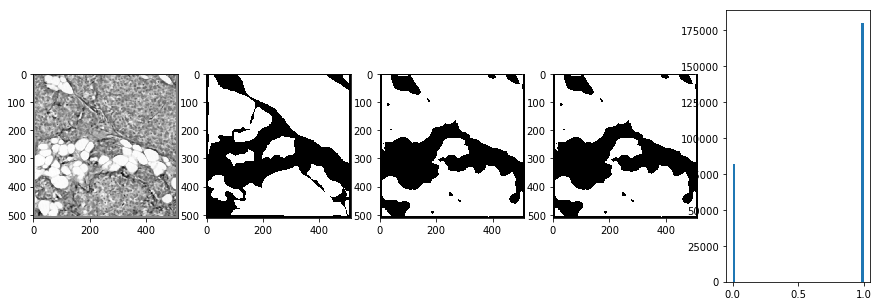

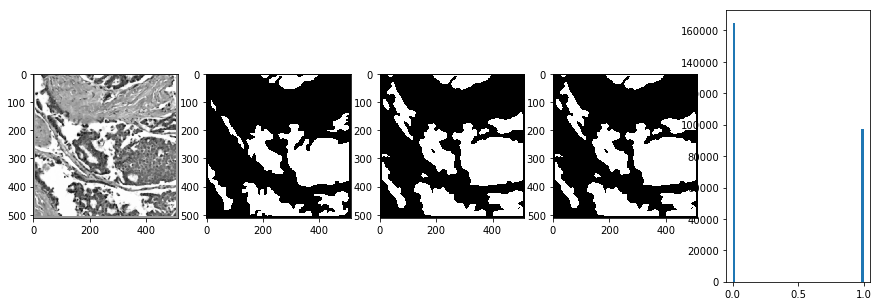

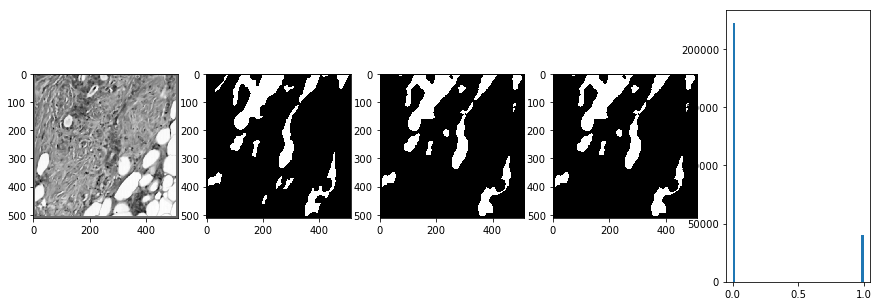

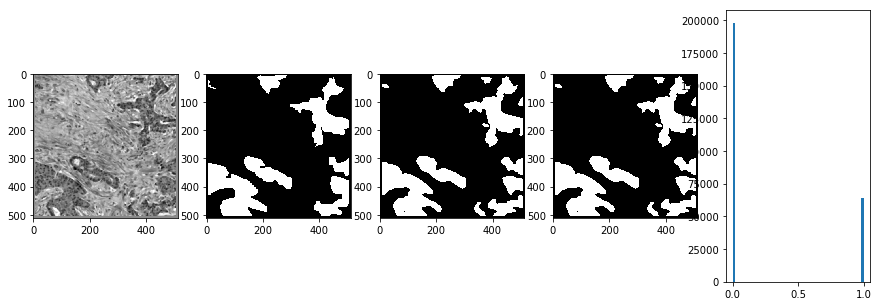

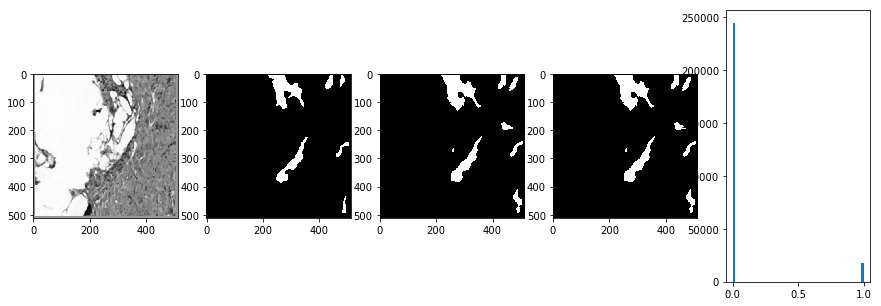

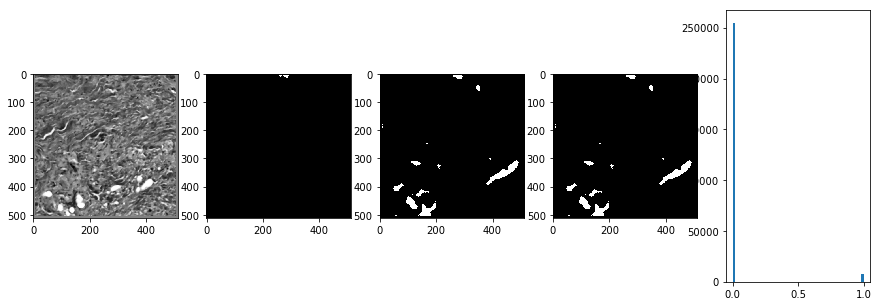

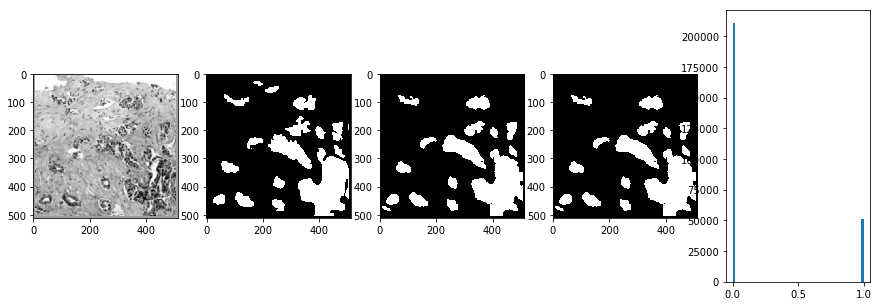

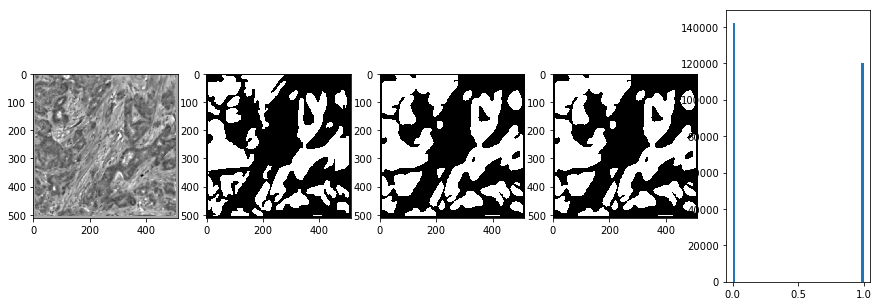

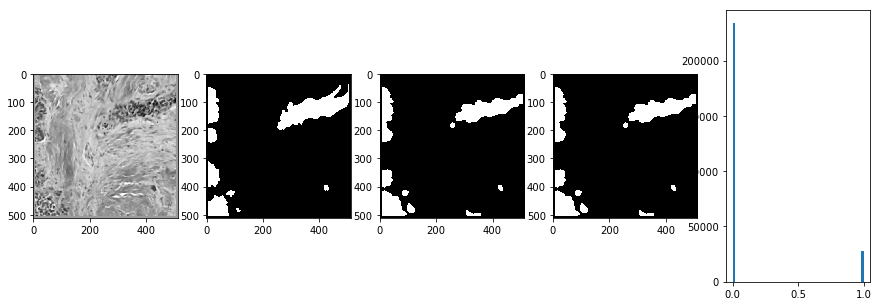

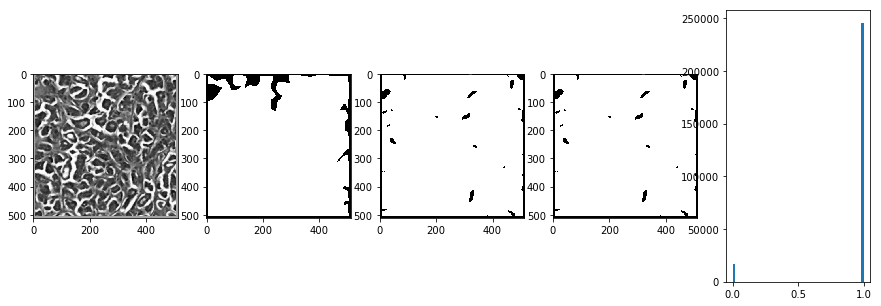

In [36]:
iii = 0
print(trX[0].shape,trY[0].shape,trP.shape,trP.min(),trP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(15,5))
    plt.subplot(151); plt.imshow(trX[ii,:,:,0],'gray'); 
    plt.subplot(152); plt.imshow(trY[ii,:,:,0],'gray'); 
    plt.subplot(153); plt.imshow(trP[ii,:,:,0],'gray'); 
    plt.subplot(154); plt.imshow(trP01[ii,:,:,0],'gray'); 
    plt.subplot(155); plt.hist(trP[ii,:,:,0].ravel(),bins=50); 
    plt.show()
plt.close()

In [37]:
# Calculate F1-micro

In [38]:
TP = (trY[:,6:506,6:506,0]*trP01[:,6:506,6:506,0]).sum()
TN = ((1.0-trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FP = ((trY[:,6:506,6:506,0])*(1.0-trP01[:,6:506,6:506,0])).sum()
FN = ((1.0-trY[:,6:506,6:506,0])*(trP01[:,6:506,6:506,0])).sum()

P  = TP/(TP+FP) if (TP+FP)>0.0 else 1.0
R  = TP/(TP+FN) if (TP+FN)>0.0 else 0.0

F1 = 2.0*P*R/(P+R) if (P+R)>0.0 else 0.0

TP,TN,FP,FN,P,R,F1
#P*R,P+R, 2.0*P*R/(P+R)

(78892848.0,
 157661254.0,
 5636472.0,
 9809426.0,
 0.93331932635918524,
 0.88941178666964049,
 0.91083671492395324)

In [39]:
# Calculate DI- dice.mean()

In [40]:
dice, XX = [],[]
for i in range(trP.shape[0]) :
    G = trY  [i,6:506,6:506,0].sum()
    S = trP01[i,6:506,6:506,0].sum()
    X = (trY [i,6:506,6:506,0]*trP01[i,6:506,6:506,0]).sum()
    XX.append(X)
    dice.append((2.0*X/(G+S) if G+S>0 else 1.0))
di = (np.array(dice)).mean()
di #,np.array(dice)  #,np.array(XX)

0.8699705575123825

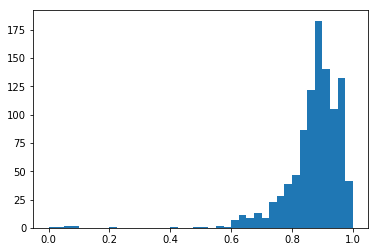

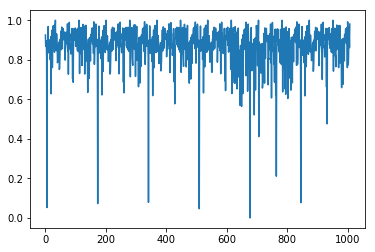

In [41]:
plt.hist(np.array(dice),bins=40); plt.show()
plt.plot(np.array(dice)); plt.show()

In [42]:
1000000*(F1+di)/2.0

890403.63621816784

In [43]:
#np.array(dice)<0.4

In [44]:
# Подготовка test решения

In [45]:
if flagGray :
    trO, trO0 = [], np.zeros((512,512,1))
else :
    trO, trO0 = [], np.zeros((512,512,3))

for xx in listTest :
    img = cv.imread(os.path.join(dirTest,xx),-1)
    if 1 and (Gauss or Median): 
        for cc in range(img.shape[2]) : 
            if Gauss  : img[:,:,cc] = cv.GaussianBlur(img[:,:,cc],(Gauss,Gauss),0);
            if Median : img[:,:,cc] = cv.medianBlur  (img[:,:,cc],Median);
    #print(img.mean(),msk.mean())
    if flagGray :
        img = cv.cvtColor(img,cv.COLOR_RGB2GRAY);
        trO0[6:506,6:506,0] = img[:,:]/255.0
    else :
        trO0[6:506,6:506,:] = img[:,:,:]/255.0
    trO.append(trO0.copy())
    #print(trX0.mean(),trY0.mean(),trX1[-1].mean(),trY1[-1].mean())

#print([trY[xx].mean() for xx in range(10)])
trO = np.array(trO)

if 1 :
    for cc in range(meanX.shape[0]) : 
        trO[:,6:506,6:506,cc] -= meanX[cc]
    
trO.shape, trO.min(), trO.max()
#[trY[xx].mean() for xx in range(10)]

((162, 512, 512, 3), -0.64172901643310909, 0.47912580261435694)

In [46]:
%time trOP = model10.predict(trO,batch_size=batch_size)

CPU times: user 14.8 s, sys: 3.31 s, total: 18.1 s
Wall time: 18.7 s


In [47]:
trOP01 = trOP
trOP01[trOP>0.5] =1.0
trOP01[trOP<=0.5]=0.0

(512, 512, 3) (512, 512, 1) (162, 512, 512, 1) 0.0 1.0


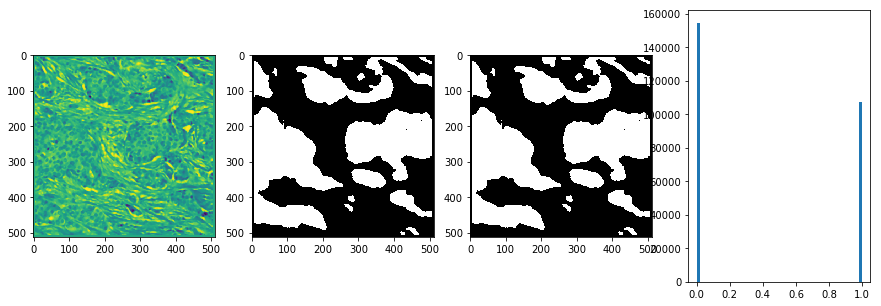

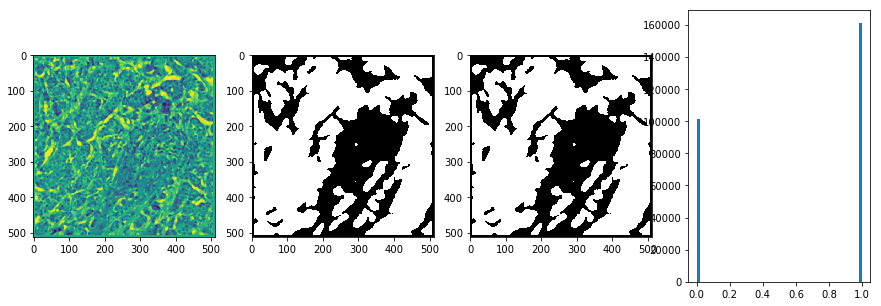

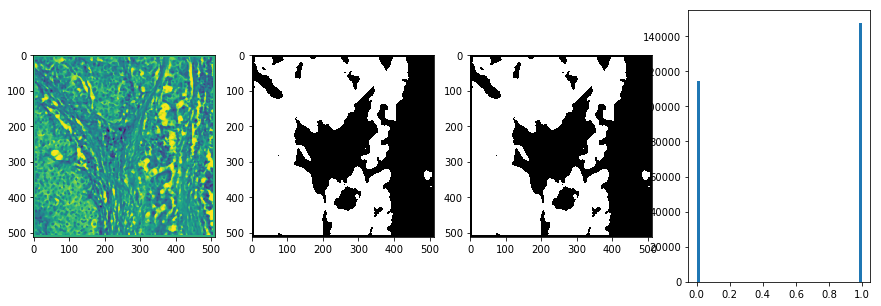

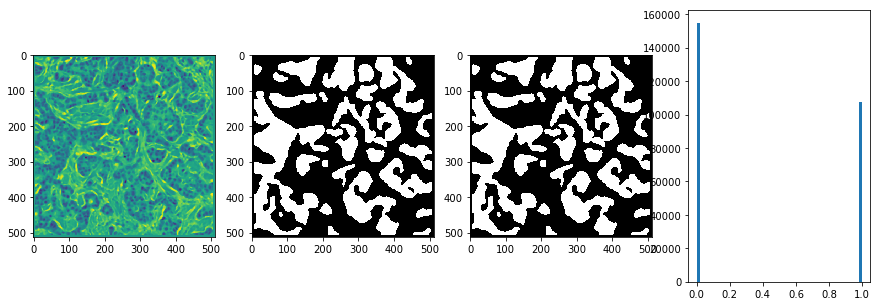

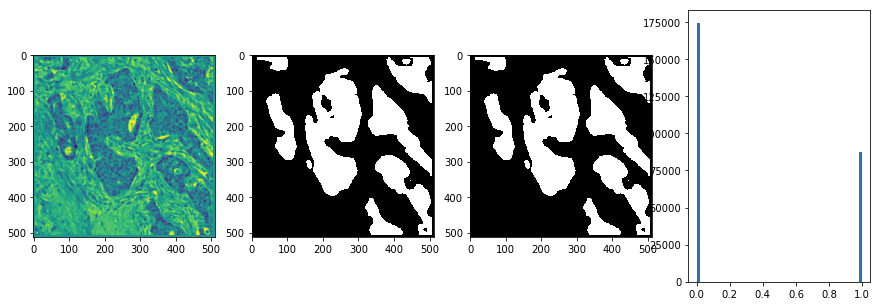

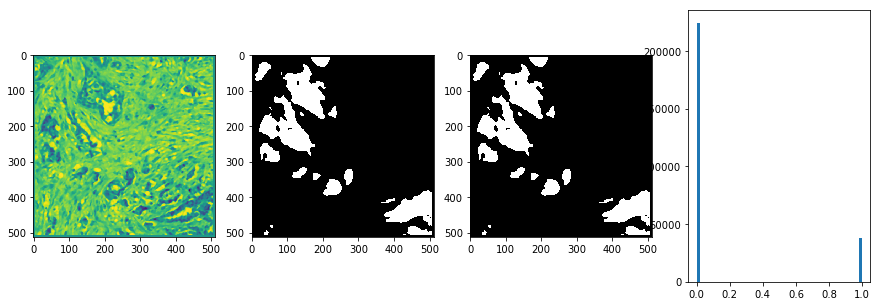

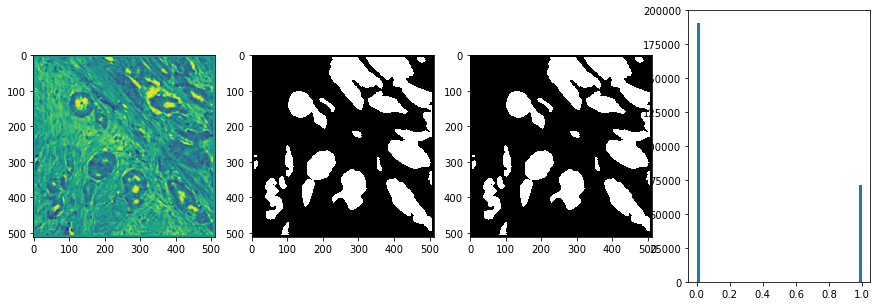

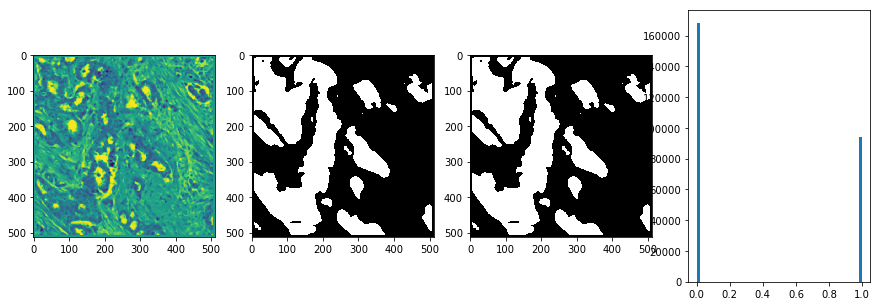

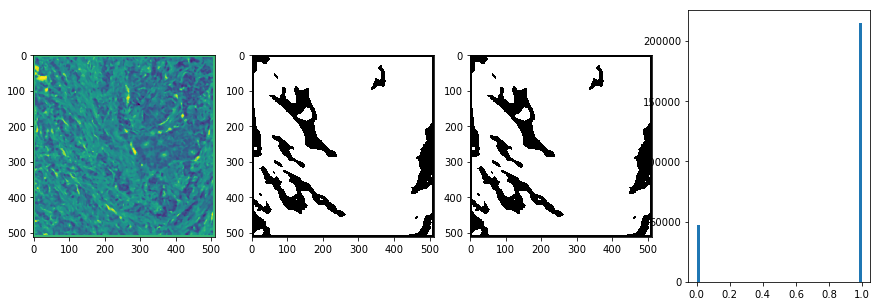

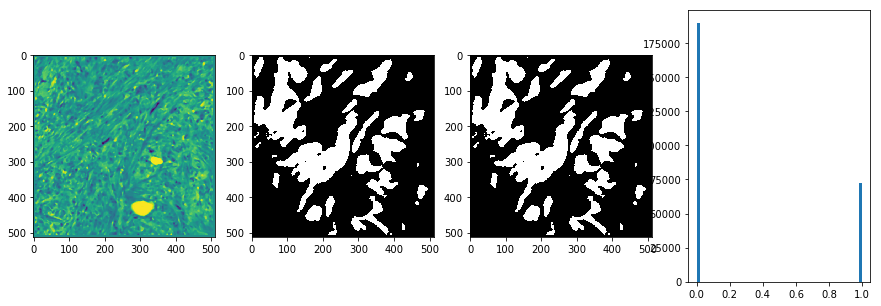

In [48]:
iii = 40
print(trO[0].shape,trP01[0].shape,trOP01.shape,trOP.min(),trOP.max())
for ii in range(iii,iii+10) :
    plt.figure(figsize=(15,5))
    plt.subplot(141); plt.imshow(trO[ii,:,:,0]); 
    plt.subplot(142); plt.imshow(trOP01[ii,:,:,0],'gray'); 
    plt.subplot(143); plt.imshow(trOP[ii,:,:,0],'gray'); 
    plt.subplot(144); plt.hist(trOP[ii,:,:,0].ravel(),bins=50); 
    plt.show()
plt.close()

In [49]:
# Формирование выходной директории

In [50]:
def convert_to_binary(truth_png_file, truth_txt_file):
    im = Image.open(truth_png_file) #Can be many different formats.
    pix = im.load()
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(pix[x, y] > 0)))
            out.write('\n')

if not os.path.exists('../Temp/random_submission'):
    os.makedirs('../Temp/random_submission')

# Training
for i in range(len(listTrain)) :
    fn = listTrain[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()
    
# Testing
for i in range(len(listTest)) :
    fn = listTest[i]
    truth_txt_file = '../Temp/random_submission/' + fn.split('.')[0] + '_mask.txt'
    with open(truth_txt_file, 'w') as out:
        for x in xrange(500):
            for y in xrange(500):
                out.write(str(int(trOP01[i,y+6, x+6] > 0.0)))
            out.write('\n')
    out.close()

In [51]:
import shutil

In [52]:
xx=shutil.make_archive('../Result/topcoderkonica','zip','../Temp/random_submission')
xx

'/media/boba/DATA/boba/Working/TopCoder/2017-07-25-Konica-Minolta/Result/topcoderkonica.zip'

In [400]:
!ls ../Temp -la

total 4610508
drwxrwxrwx 1 boba boba      4096 июл 26 10:58 .
drwxrwxrwx 1 boba boba      4096 июл 26 10:11 ..
drwxrwxrwx 1 boba boba         0 июл 25 18:17 .ipynb_checkpoints
drwxrwxrwx 1 boba boba     61440 июл 26 09:14 random_submission
-rwxrwxrwx 1 boba boba   1057596 июл 26 10:58 random_submission.zip
drwxrwxrwx 1 boba boba         0 июл 25 23:35 TrainModel001-G-M
drwxrwxrwx 1 boba boba         0 июл 25 22:21 TrainModel001-G+M
drwxrwxrwx 1 boba boba         0 июл 25 21:48 TrainModel001+G-M
drwxrwxrwx 1 boba boba      4096 июл 25 21:05 TrainModel001+G+M
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:02 V1-UNET-0.8167.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:08 V1-UNET-0.8275.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:33 V1-UNET-0.8305.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 18:02 V1-UNET-0.8418.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8486.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 19:09 V1-UNET-0.8593.hdf5
-rwxrwxrwx 1 boba boba 248418336 июл 25 

In [389]:
!ls ../Work -la
#!ls ../Temp/random_submission

total 80768
drwxrwxrwx 1 boba boba        0 июл 26 09:17 .
drwxrwxrwx 1 boba boba     4096 июл 25 15:24 ..
-rwxrwxrwx 1 boba boba 82700662 июл 26 09:32 topcoderkonica.zip


In [36]:
if False :
    save_model(model10,'../Data-Keras/Models/model-UNet.h5')
    model10.save_weights('../Data-Keras/Models/model-UNet-weights.h5')

In [41]:
rrr=pd.DataFrame(res,columns=['image_name','tags']); rrr.head(); 
suffixDT = (datetime.datetime.now()).strftime('%Y-%m-%d-%H-%M-%S'); print(suffixDT)
rrr.to_csv('../Result/vss'+suffixDT+'.csv',index=False);

2017-05-20-05-51-18
